# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Paige Park

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [4]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

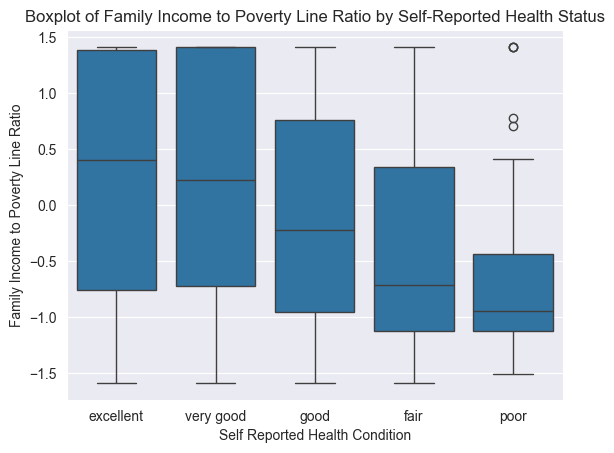

In [5]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

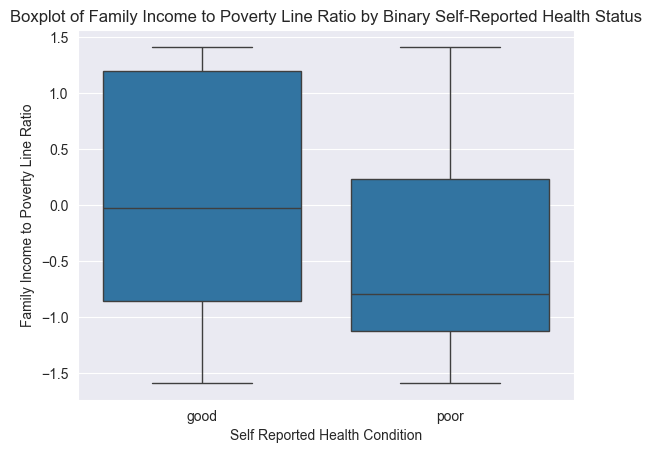

In [6]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

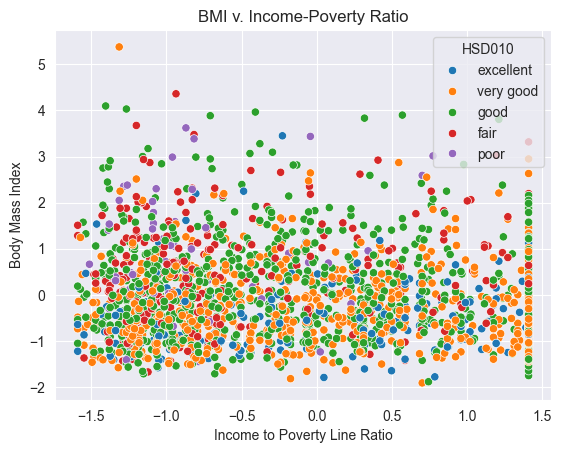

In [7]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [8]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

To start, I'll choose a relatively high number of components (150) so that I can examine the distribution of variance explained by each component and narrow down the number of features based on the results. I want to include a smaller number of features that explain the greatest amount of variance in the final model.

In [31]:
## PCA (fitting to data, transforming the data, creating dataframe)
pca = PCA(n_components=150)
pca.fit(nhanes_scaled)
nhanes_pca = pca.transform(nhanes_scaled)
#nhanes_pca_df = pd.DataFrame(data=nhanes_pca, columns=['PC1', 'PC2'])

### Barplot of Components

The barplot shows that component 1 explains around 10% of the variation in the data, component 2 explains about 8%, and subsequent components decrease from there in a fairly regular way. Because the first few components don't explain a majority of the variation, we might want to keep more of the components than we otherwise would. In this case, it takes 150 components to capture around 96% of the variation.

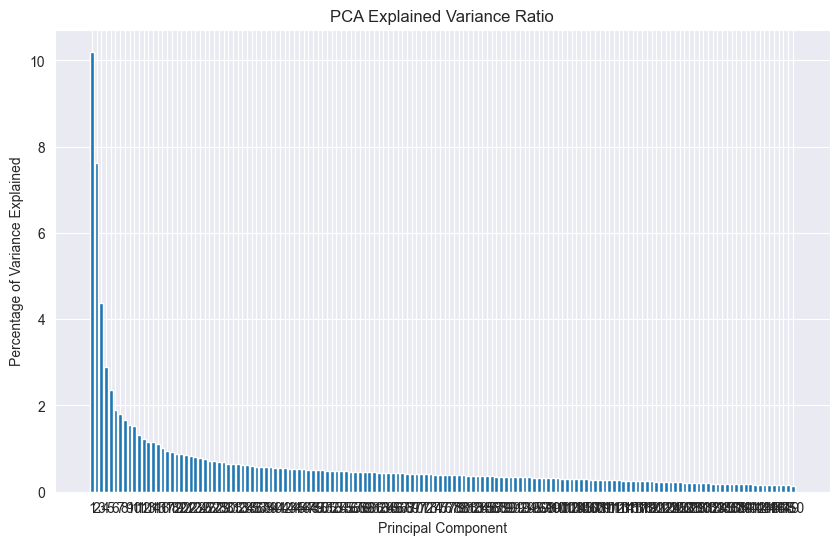

In [32]:
## plot explained variance ratio
percent_variance = pca.explained_variance_ratio_ * 100
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(percent_variance) + 1), percent_variance)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('PCA Explained Variance Ratio')
plt.xticks(range(1, len(percent_variance) + 1))
plt.show()

In [33]:
percent_variance.sum()

95.81858667350957

### How many components will you use to fit a supervised learning model?

Deciding how many components to use in a supervised model involves a trade-off between the amount of variance the components are able to capture and interpretabiltiy/simplicity. It seems like it would be good to reduce the number of components I'm using since 150 is still a very large number of features. I will take a hit on how much variance the components capture in exchange for additional dimensionality reduction. Let's see how much variance is captured by half as many features (75).  

In [34]:
## PCA (fitting to data, transforming the data)
pca = PCA(n_components=75)
pca.fit(nhanes_scaled)
nhanes_pca = pca.transform(nhanes_scaled)

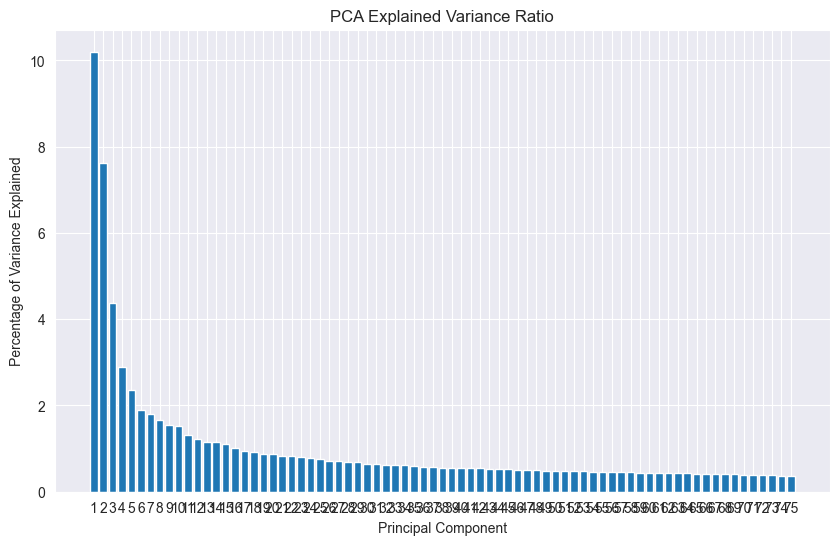

In [106]:
## plot explained variance ratio
percent_variance = pca.explained_variance_ratio_ * 100
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(percent_variance) + 1), percent_variance)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('PCA Explained Variance Ratio')
plt.xticks(range(1, len(percent_variance) + 1))
plt.show()

75 components capture about 75% of the variation in the data and are less unwieldy than using the original set of 150 features. I will use 75 components for the supervised model, but if this were a project I had more time and energy for, I might try out different numbers of components in the neural networks to see which number gives the best results. 

In [36]:
percent_variance.sum()

75.65568808008979

### 2D Scatterplot of the first two components

The scatterplot below shows that there are some observations that appear to be clear outliers, especially with respect to the first component. Otherwise, the plot indicates that there might be two clusters of data - one larger cluster in the bottom left of the plot and the other in the top left. 

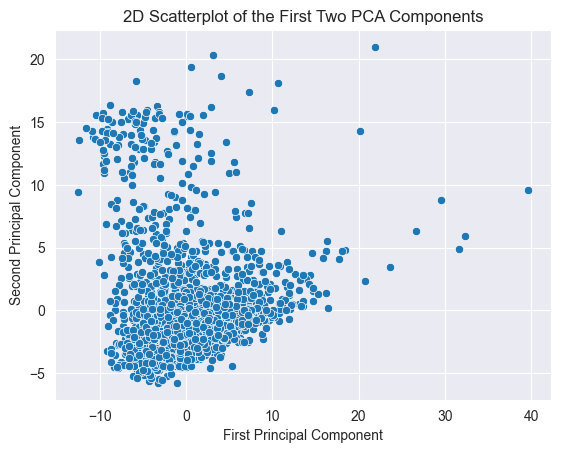

In [47]:
plot = sns.scatterplot(x = nhanes_pca[:, 0], y = nhanes_pca[:, 1], data = nhanes_scaled)
plot.set(xlabel = "First Principal Component",
      ylabel = "Second Principal Component")
plot.set_title("2D Scatterplot of the First Two PCA Components")
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I'm choosing the K-means algorithm. This algorithm iteratively sorts data into a pre-defined number of clusters, k, based on the Euclidean distance between data points and cluster centroids (at least in this case, though other distance measures can be used). 

### Cluster nhanes

The elbow method plot shows that at around 4 clusters, the inertia starts decreasing linearly indicating that k=4 is the "elbow" of the plot and we should select 4 for k in our algorithm. 

/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureW

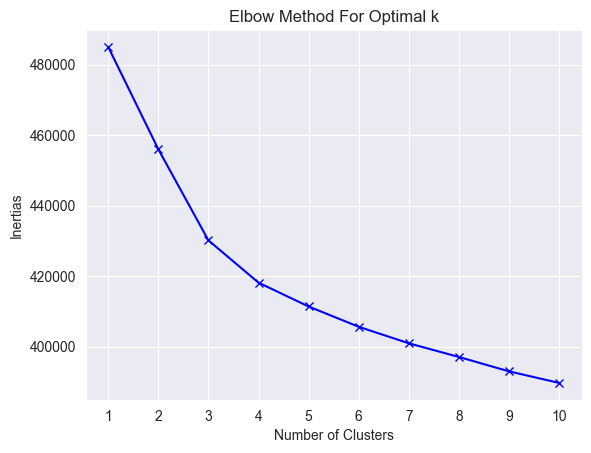

In [41]:
# elbow method - plotting inertia as a function of the number of clusters 
inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(nhanes_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, 'bx-')
plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('Elbow Method For Optimal k')
plt.show()

In [55]:
# carrying out the k-means algorithm 
kmeans = KMeans(n_clusters=4, random_state=4)
kmeans.fit(nhanes_scaled)

# get the cluster assignments for each data point
cluster_kmeans = kmeans.predict(nhanes_scaled)

/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

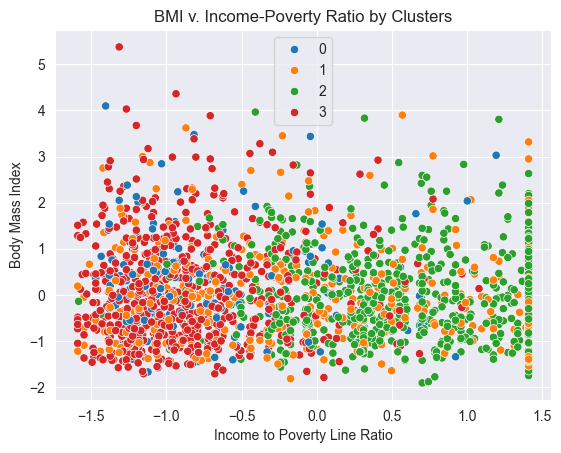

In [56]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = cluster_kmeans, palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio by Clusters")
plt.show()

The green cluster is concentrated on the higher end of the income to poverty line ratio than the red or blue clusters which are both highly concentrated among the lower ratios. The orange points seem to be randomly distributed on this plot and don't demonstrate an obvious pattern. None of the clusters seem to be strongly defined by BMI. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureW

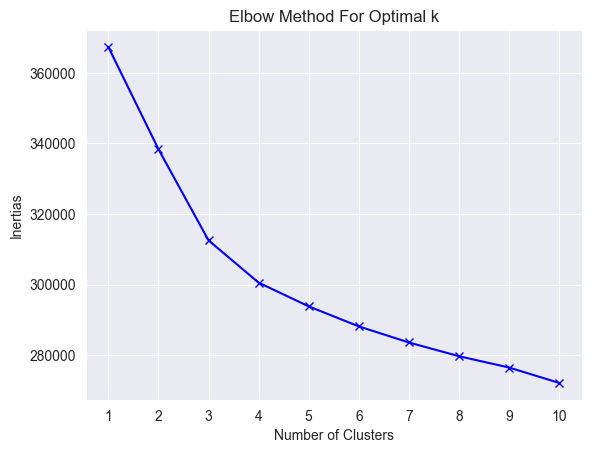

In [45]:
# elbow method - plotting inertia as a function of the number of clusters 
inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(nhanes_pca)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, 'bx-')
plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('Elbow Method For Optimal k')
plt.show()

In [58]:
# carrying out the k-means algorithm 
kmeans = KMeans(n_clusters=4, random_state=4)
kmeans.fit(nhanes_pca)

# get the cluster assignments for each data point
cluster_kmeans = kmeans.predict(nhanes_pca)

/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


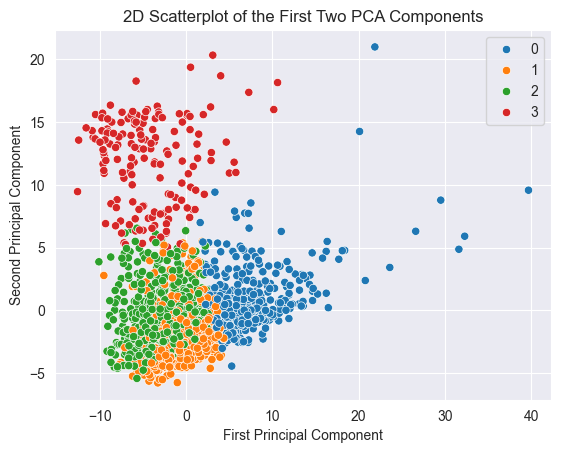

In [59]:
plot = sns.scatterplot(x=nhanes_pca[:, 0], y=nhanes_pca[:, 1], hue=cluster_kmeans, palette = "tab10", data=nhanes_scaled)
plot.set(xlabel = "First Principal Component",
      ylabel = "Second Principal Component")
plot.set_title("2D Scatterplot of the First Two PCA Components")
plt.show()

The clusters trained on the PCA components are much more clearly defined than those trained on the raw data. We see 4 distinctly seperated groups in the plot below, though the separation between the green and orange points seems arbitrary and not clearly defined. The blue and red clusters on the other hand are clearly seperated from each other and the other two clusters. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [124]:
# partition data
# -----------
y = hsd010_binary # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.25, 
                                                    random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=.2,
                                                  random_state=10)

In [125]:
# load libraries
# -----------
import keras

# convert y_train and y_test to integers 
y_train = y_train.map({'good': 1, 'poor': 0})
y_test = y_test.map({'good': 1, 'poor': 0})
y_val = y_val.map({'good': 1, 'poor': 0})

# don't need to use one hot encoding since the binary version of y is already in a binary format    
    # num_classes = 2
    # convert class vectors to binary class matrices
    # y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
    # y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
    # num_classes = y_test.shape[1]

int64
2


In [126]:
# create neural network model
# -----------
model = Sequential()
model.add(keras.Input(shape=(241,)))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128, verbose=2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                15488     
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 15553 (60.75 KB)
Trainable params: 15553 (60.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
10/10 - 0s - loss: 0.5172 - accuracy: 0.7730 - val_loss: 0.4815 - val_accuracy: 0.7903 - 366ms/epoch - 37ms/step
Epoch 2/50
10/10 - 0s - loss: 0.3785 - accuracy: 0.8457 - val_loss: 0.4456 - val_accuracy: 0.8129 - 31ms/epoch - 3ms/step
Epoch 3/50
10/10 - 0s - loss: 0.3236 - accuracy: 0.8740 - val_loss: 0.4383 - val_accuracy: 0.8226 - 31ms/epoch - 3ms/step
Epoch 4/50
10/10 - 0s - loss: 0.2928 - accura

### Neural Network on Principal Components

In [129]:
# partition data
# -----------
y = hsd010_binary # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_pca # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.25, 
                                                    random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=.2,
                                                  random_state=10)

# convert y_train and y_test to integers 
y_train = y_train.map({'good': 1, 'poor': 0})
y_test = y_test.map({'good': 1, 'poor': 0})
y_val = y_val.map({'good': 1, 'poor': 0})

In [130]:
# create neural network model
# -----------
model = Sequential()
model.add(keras.Input(shape=(75,)))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128, verbose=2)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                4864      
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4929 (19.25 KB)
Trainable params: 4929 (19.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
10/10 - 0s - loss: 0.5377 - accuracy: 0.7617 - val_loss: 0.4985 - val_accuracy: 0.7581 - 384ms/epoch - 38ms/step
Epoch 2/50
10/10 - 0s - loss: 0.4215 - accuracy: 0.8376 - val_loss: 0.4502 - val_accuracy: 0.8097 - 28ms/epoch - 3ms/step
Epoch 3/50
10/10 - 0s - loss: 0.3635 - accuracy: 0.8675 - val_loss: 0.4341 - val_accuracy: 0.8323 - 29ms/epoch - 3ms/step
Epoch 4/50
10/10 - 0s - loss: 0.3327 - accuracy: 0.8788 - val_loss: 0.4254 - val_accuracy: 0.8419 - 28ms/epoch - 3ms/step
Epoch 5/50
10/10 - 0s - loss: 0.3100 - accuracy: 0.8853 - val_loss: 0.4192 - val_accuracy: 0.8419 - 29ms/epoch - 3ms/step
Epoch 6/50
10/10 - 0s - loss: 0.2939 - accuracy: 0.8877 - val_loss: 0.4165 - val_accuracy: 0.8484 - 36ms/epoch - 4ms/step
Epoch 7/50
10/10 - 0s - loss: 0.2816 - accuracy: 0.8974 - val_loss: 0.4161 - val_accuracy: 0.8419 - 31ms/epoch - 3ms/step
Epoch 8/50
10/10 - 0s - loss: 0.2706 - accuracy: 0.8998 - val_loss: 0.4182 - val_accuracy: 0.8419 - 32ms/epoch - 3ms/step
Epoch 9/50
10/10 - 0s 

### Neural Network on Principal Components + Cluster Membership

In [131]:
nhanes_pca_and_cluster = np.column_stack((nhanes_pca, cluster_kmeans))
nhanes_pca_and_cluster.shape

(2064, 76)

In [132]:
# partition data
# -----------
y = hsd010_binary # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_pca_and_cluster # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.25, 
                                                    random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=.2,
                                                  random_state=10)

# convert y_train and y_test to integers 
y_train = y_train.map({'good': 1, 'poor': 0})
y_test = y_test.map({'good': 1, 'poor': 0})
y_val = y_val.map({'good': 1, 'poor': 0})

In [133]:
# create neural network model
# -----------
model = Sequential()
model.add(keras.Input(shape=(76,)))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128, verbose=2)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 64)                4928      
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4993 (19.50 KB)
Trainable params: 4993 (19.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
10/10 - 0s - loss: 0.6542 - accuracy: 0.6672 - val_loss: 0.5728 - val_accuracy: 0.7323 - 338ms/epoch - 34ms/step
Epoch 2/50
10/10 - 0s - loss: 0.5004 - accuracy: 0.7876 - val_loss: 0.5027 - val_accuracy: 0.7903 - 28ms/epoch - 3ms/step
Epoch 3/50
10/10 - 0s - loss: 0.4159 - accuracy: 0.8352 - val_loss: 0.4628 - val_accuracy: 0.8129 - 29ms/epoch - 3ms/step
Epoch 4/50
10/10 - 0s - loss: 0.3658 - accuracy: 0.8611 - val_loss: 0.4412 - val_accuracy: 0.8161 - 27ms/epoch - 3ms/step
Epoch 5/50
10/10 - 0s - loss: 0.3334 - accuracy: 0.8732 - val_loss: 0.4290 - val_accuracy: 0.8194 - 28ms/epoch - 3ms/step
Epoch 6/50
10/10 - 0s - loss: 0.3114 - accuracy: 0.8788 - val_loss: 0.4238 - val_accuracy: 0.8290 - 29ms/epoch - 3ms/step
Epoch 7/50
10/10 - 0s - loss: 0.2952 - accuracy: 0.8821 - val_loss: 0.4200 - val_accuracy: 0.8226 - 29ms/epoch - 3ms/step
Epoch 8/50
10/10 - 0s - loss: 0.2807 - accuracy: 0.8869 - val_loss: 0.4206 - val_accuracy: 0.8355 - 29ms/epoch - 3ms/step
Epoch 9/50
10/10 - 0s 

### Model Comparison and Conclusions
Validation accuracy is the most important metric to consider when comparing models. We're not very interested in how well the model fits to the training data and instead want something that can generalize to unseen cases. Rather than consider the final validation accuracy after all epochs of training, we want to compare each model's peak validation accuracy (i.e. the validation accuracy computed before the models start overfitting). The model with the highest peak validation accuracy is model 2, trained on the PCA components rather than the features. This model achieved a peak validation accuracy of 0.8484 (achieved at epoch 6) while peak for model 1 was 0.8452 and peak for model 3 was 0.8290. Thus, we would want to use the principal components as features rather than the original features to achieve maximum generalizability. However, I've done no tuning on the hyperparameters used in the models above and there could be differences in performance depending on how many principal components we choose to use in the model. Additional tuning and experimenting might result in a different featurization choice. 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

**PCA is a tool that can be used for dimensionality reduction and is a way of summarizing latent concepts in a dataset with many features. PCA can summarize most of the variation in the data in a much smaller number of components which reduces complexity and provides information about which features contribute to certain larger concepts. For example, PCA might result in the creation of 2 or 3 components that represent latent features in the data like socioeconomic status, geographic location, and health that more succintly capture patterns from hundreds of more specific features. The goals of clustering are different. Rather than dimensionailty reduction or latent feature construction (using other features), clustering simply sorts all observations into distinct groups of similar types of observations. This gives us more information about the observations or research subjects themselves and how they are similar to other subjects (instead of giving us information about the features that contribute most to underlying concepts in the data or reducing dimensionality).**

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

**I did not see any advantages to combining PCA and clustering. In fact, adding the clusting variable hurt the validation accuracy. This likely means that the clustering results is an uninformative feature for predicting health status.**

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

**Unsupervised learning techniques can help to prepare data for inclusion in supervised models like neural networks. Dimension-reduction techniques like PCA can be thought of as forms of feature engineering that help to eliminate uninformative features and reveal the underlying structure of the data. The problem of uninformative features and ambiguous structure are particularly potent in very large datasets with lots of features; many features might only contribute noise. The better we can prepare our data for inclusion in a deep learning model (or another ML model), the easier it will be for the model to identify patterns and make predictions on unseen data.**